## Import Libraries

In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = [10, 8]

## Define Constants/Helpers

In [2]:
N = 4
N_filled = N // 2
E_neg1 = 0
P_neg1 = np.exp(-1j * E_neg1)
t = -0.5
g = 1
m = 1
PBC = True

In [3]:
def stringbox(lst, caption):
    return caption + "-" * (100 - len(caption))+"\n" + str(lst) + "\n" + "-" * 100

## Spin Basis Simulation

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [-0.5, 3, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [-0.5, 0, 3]]], ['+-', [[1, 0, 0], [-1, 1, 1], [1, 2, 2], [-1, 3, 3]]], ['+-', [[0, 0, 0]]], ['+-+-', [[0, 0, 0, 0, 0]]], ['+-', [[0, 0, 0], [0, 1, 1]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1]]], ['+-', [[0, 0, 0], [0, 1, 1], [0, 2, 2]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 2], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1], [0, 1, 1, 2, 2], [0, 2, 2, 0, 0], [0, 2, 2, 1, 1], [0, 2, 2, 2, 2]]], ['+-', [[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 2], [0, 0, 0, 3, 3], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1], [0, 1, 1, 2, 2], [0, 1, 1, 3, 3], [0, 2, 2, 0, 0], [0, 2, 2, 1, 1], [0, 2, 2, 2, 2], [0, 2, 2, 3, 3], [0, 3, 3, 0, 0], [0, 3, 3, 1, 1], [0, 3, 3, 2, 2], [0, 3, 3, 3, 3]]]]
--------

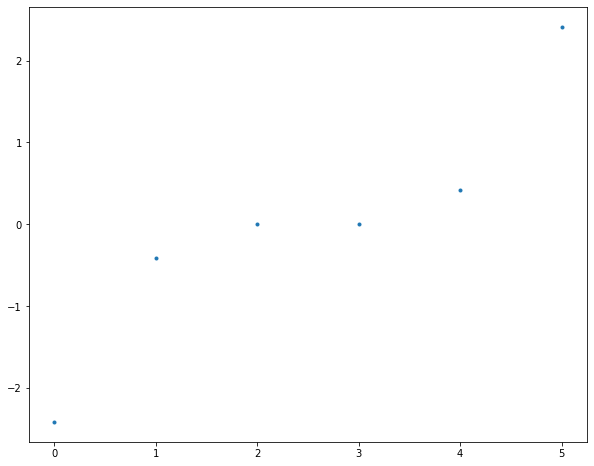

In [4]:
spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
if PBC and N_filled % 2 == 0:
    hop_coupling[-1][0] = -hop_coupling[-1][0]
    hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
def E_squared(n):
    E_const = E_neg1 - (n + 1) // 2
    s_coupling = []
    d_coupling = []
    for i in range(n + 1):
        s_coeff = 2 * E_const * -g
        s_coupling += [[s_coeff, i, i]]
        for j in range(n + 1):
            d_coeff = -g
            d_coupling += [[d_coeff, i, i, j, j]]
    return [["+-", s_coupling], ["+-+-", d_coupling]]
for i in range(N):
    static_terms += E_squared(i)

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)
spin_eigvals = H.eigvalsh()
plt.plot(spin_eigvals, ".")
plt.show()

## Fermion Basis

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [0.5, 3, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [0.5, 0, 3]]], ['+-', [[1, 0, 0], [-1, 1, 1], [1, 2, 2], [-1, 3, 3]]], ['z', [[(2+0j), 0]]], ['zz', [[(4+0j), 0, 1]]], ['zzz', [[(-8+0j), 0, 1, 2]]], ['zzzz', [[(-16+0j), 0, 1, 2, 3]]]]
----------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


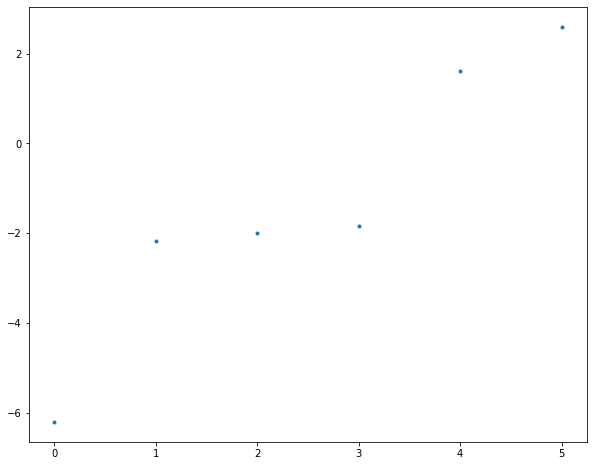

In [5]:
fermion_basis = spinless_fermion_basis_1d(L=N, Nf=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
E_link_parity = lambda x : -1 if (x % 4) < 2 else 1
for i in range(N):
    E_coupling = [P_neg1 * -g * E_link_parity(i) * 2 ** (i+1)] + list(range(i+1))
    static_terms += [["z" * (i+1), [E_coupling]]]

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
fermion_eigvals = H.eigvalsh()
plt.plot(fermion_eigvals, ".")
plt.show()

## Comparison

In [6]:
mdiff = max(abs(fermion_eigvals - spin_eigvals))
print(stringbox(fermion_eigvals, "Fermion eigenvalues:"))
print(stringbox(spin_eigvals, "Spin eigenvalues:"))
print("Maximum difference between eigenvalues:", mdiff)

Fermion eigenvalues:--------------------------------------------------------------------------------
[-6.20875976 -2.17253501 -2.         -1.83442686  1.6179029   2.59781873]
----------------------------------------------------------------------------------------------------
Spin eigenvalues:-----------------------------------------------------------------------------------
[-2.4142139e+00 -4.1421366e-01 -2.8450222e-08 -1.7031356e-08
  4.1421354e-01  2.4142146e+00]
----------------------------------------------------------------------------------------------------
Maximum difference between eigenvalues: 3.794545862593923
